# Waveform plot 
This will download continuous seismic waveforms & plot them and requires ObsPy

## Import ObsPy module

In [19]:
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.1


## Set client (Data Center)
This example uses IRIS. We can use other dataceneter (e.g., NCEDC, SCEDC)

In [20]:
#client = Client("NCEDC") # data from NCEDC 
#client = Client("SCEDC") # data from SCEDC
client = Client("IRIS") # data from IRIS

## Set SNCL
Which SNCL (Station, Network, Component, Location)? 

In [21]:
#http://ds.iris.edu/mda/NV/NSMTC/
sta = "NSMTC" # station
net = "NV" # network
com = "C?Z" # to get all SA-ULN and Geophone Z data
loc = "*" # use wildcard to get all location but later I only use CNZ.B2 for the metadata check


In [22]:
# separately added PGC data for comparison
#http://ds.iris.edu/mda/CN/PGC/--/HHZ/?starttime=2017-08-10T18:10:00&endtime=2599-12-31T23:59:59
sta2 = "PGC" # station
net2 = "CN" # network
com2 = "H?Z" # component # HHZ or HNZ. HHZ is broadband and HNZ is accelerometer
loc2 = "--" # location
client2 = Client("IRIS") # data from IRIS

## Set time window
This example uses 2-hour data for the 2020 M6.8 Philippines earthquake

In [23]:
#M 8.2 - 101km SSW of Tres Picos, Mexico
#2017-09-08 04:49:19 (UTC)15.022°N 93.899°W47.4 km depth

start_day = "2017-09-08T04:49:19"
end_day = "2017-09-08T05:49:19"

starttime = UTCDateTime(start_day)
endtime = UTCDateTime(end_day)

## Download seismic data collected at Cascadia experiment
use get_waveforms to download data and do st.plot() for plotting 

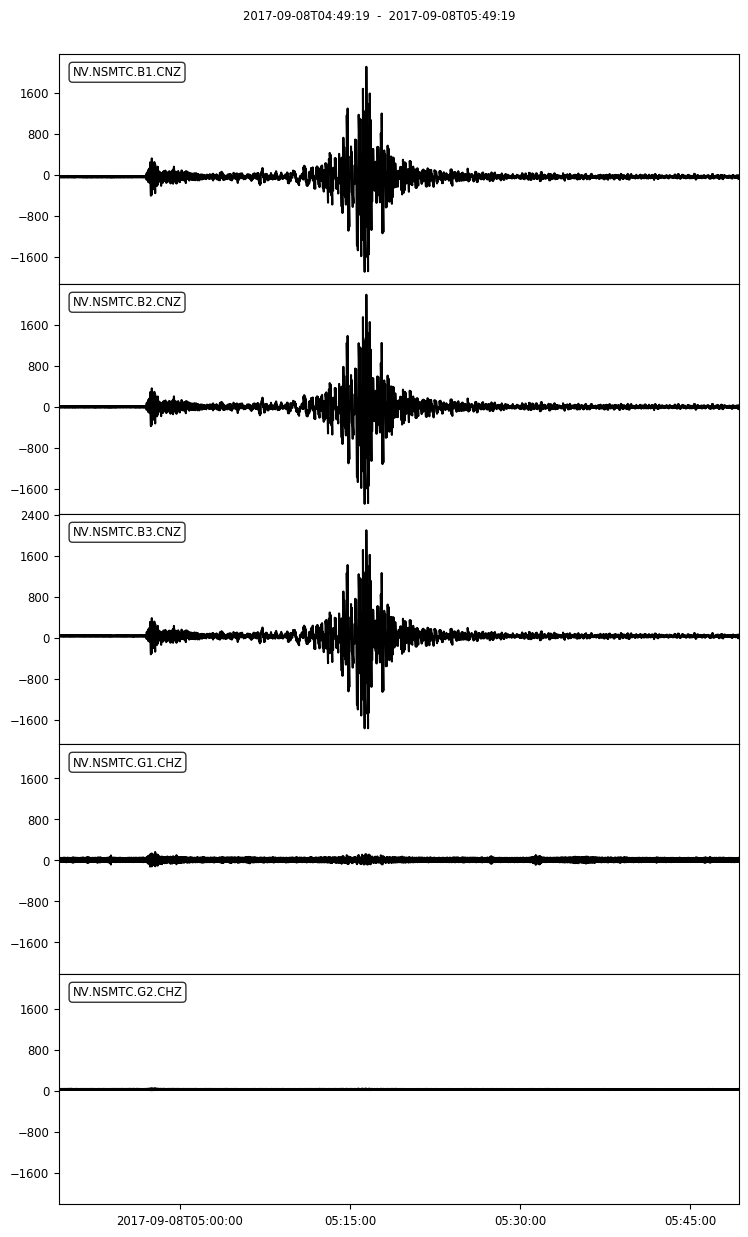

In [24]:
# st is Cascadia data
st = client.get_waveforms(network=net, station=sta, location=loc, channel=com,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
_plot = st.plot()

# Copy original data


In [7]:
# st_mod is for an update metadata. we will use st_mod below
st_mod = st.copy()

## Download seismic data collected at CN.PGC data
 

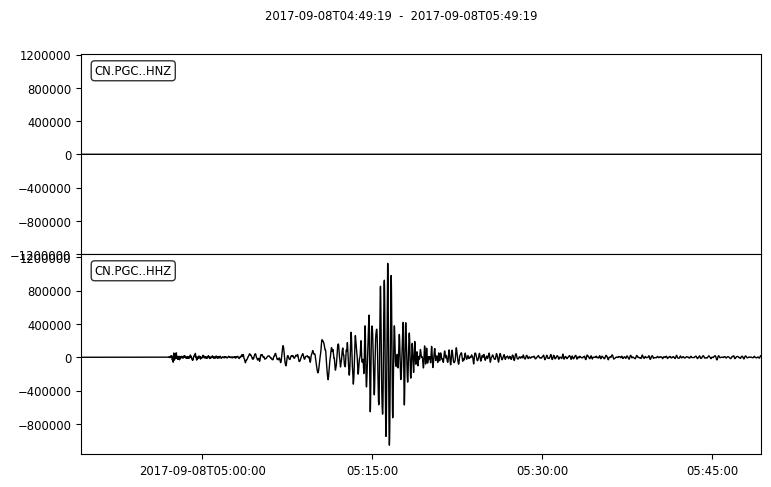

In [8]:
# st2 is referect PGC data
st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
_plot = st2.plot()

## Correct instrument response for NV.NSMTC
use remove_response to correct the instrument response. We can select output unit (displacement, velocity or accerelation)

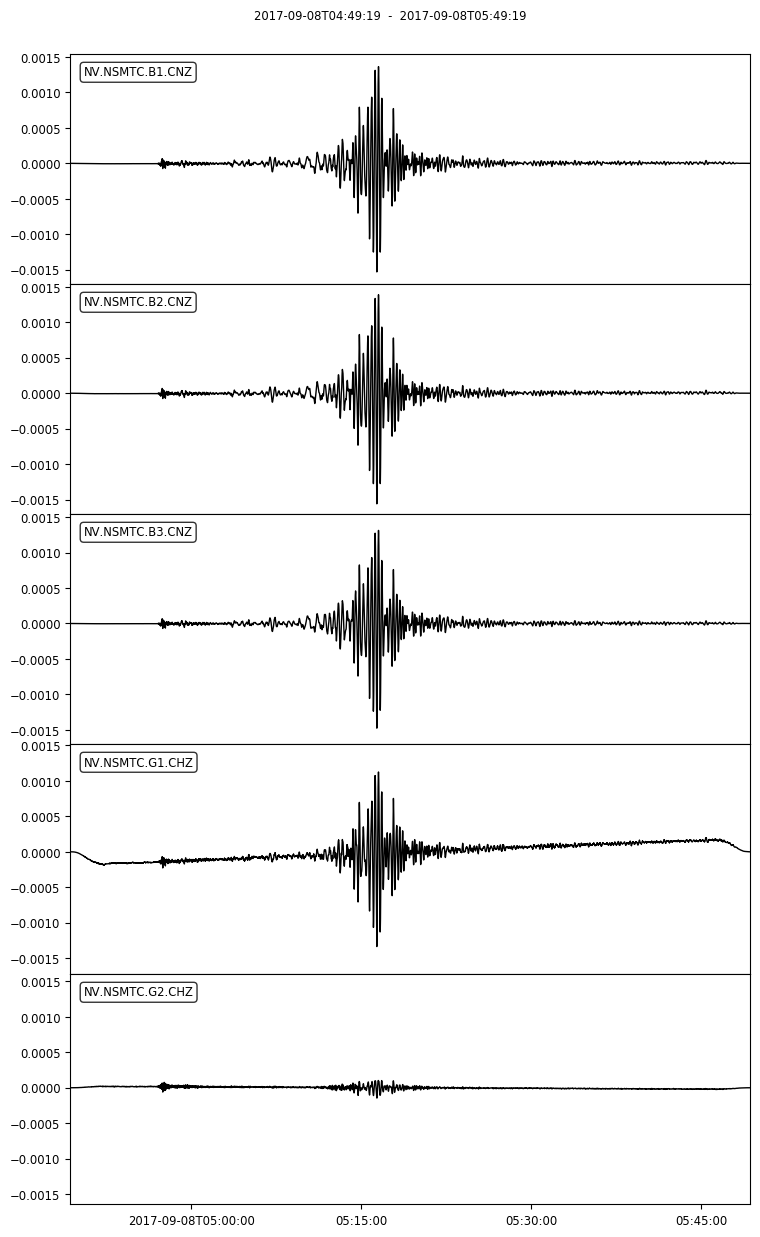

In [9]:
# select B2.CNZ data here to compere the metadata
# st = st.select(id="NV.NSMTC.B2.CNZ")

st.detrend() # remove liner trend
st.detrend("demean") # demean
st.taper(0.05) # cosin tape
# decimate to 100Hz
st.decimate(factor=5, strict_length=False)

st = st.remove_response( output="VEL", water_level=80) # get velocity data (m/s)
#st = st.remove_response( output="DISP" ) # get displacement data (m)
#st = st.remove_response( output="ACC" ) # get acceleration data (m/s^2)
_plot = st.plot()


## Update channel name

In [15]:
# updated channel name so that when we plot data we can see the sensor gain value info.
st[0].stats.channel = "CNZ-60V/g"

## Correct instrument response for CN.PGC

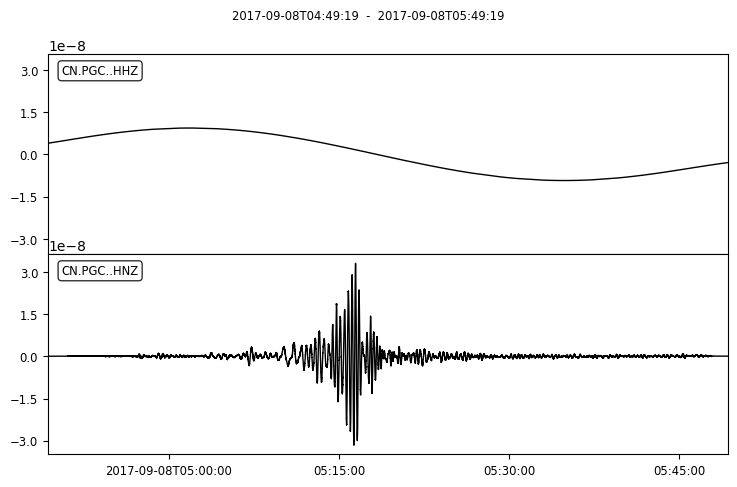

In [16]:
st2.detrend() # remove liner trend
st2.detrend("demean") # demean
st2.taper(0.05) # cosin tape
st2 = st2.remove_response( output="VEL" ) # get velocity data (m/s)
#st = st.remove_response( output="DISP" ) # get displacement data (m)
#st = st.remove_response( output="ACC" ) # get acceleration data (m/s^2)
_plot = st2.plot()

## Select B2.CNZ data

In [17]:
# select B2.CNZ data only 
st_mod = st_mod.select(location='B*')
print(st_mod)

0 Trace(s) in Stream:



## Modify sensor gain value

In [18]:
# modify sensor gain 60V/g -> 40V/g
# also x -1 to polarity flip
print("# original gain value = ",st_mod[0].stats.response.response_stages[0].stage_gain)
for tr in st_mod:
    tr.stats.response.response_stages[0].stage_gain =  (40.0 / 9.80665) * -1 # 40V/g also include polarity flip
    tr.stats.response.recalculate_overall_sensitivity()
print("# updated  gain value = ",st_mod[0].stats.response.response_stages[0].stage_gain)


IndexError: list index out of range

In [13]:
## Correct instrument response for G2.CNZ data with an updated resp file

# remove instrument response for st_mod
st_mod.detrend() # remove liner trend
st_mod.detrend("demean") # demean
st_mod.taper(0.05) # cosin tape

# decimate to 100Hz
st_mod.decimate(factor=5, strict_length=False)
st_mod = st_mod.remove_response( output="VEL", water_level=60) # get velocity data (m/s)

_plot = st_mod## Correct instrument response for CN.PGC.plot()


## Update channel name and location code

# updated channel name so that when we plot data we can see the sensor gain value info.
# location code is B2 -> A2 so that tihs treace would be plotted before B2 data. only plotting purpose
for tr in st_mod:
    tr.stats.channel = "CNZ-40V/g x -1"
    tr.stats.location = "A{}".format(tr.stats.location[-1])

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


## Filtering and plot

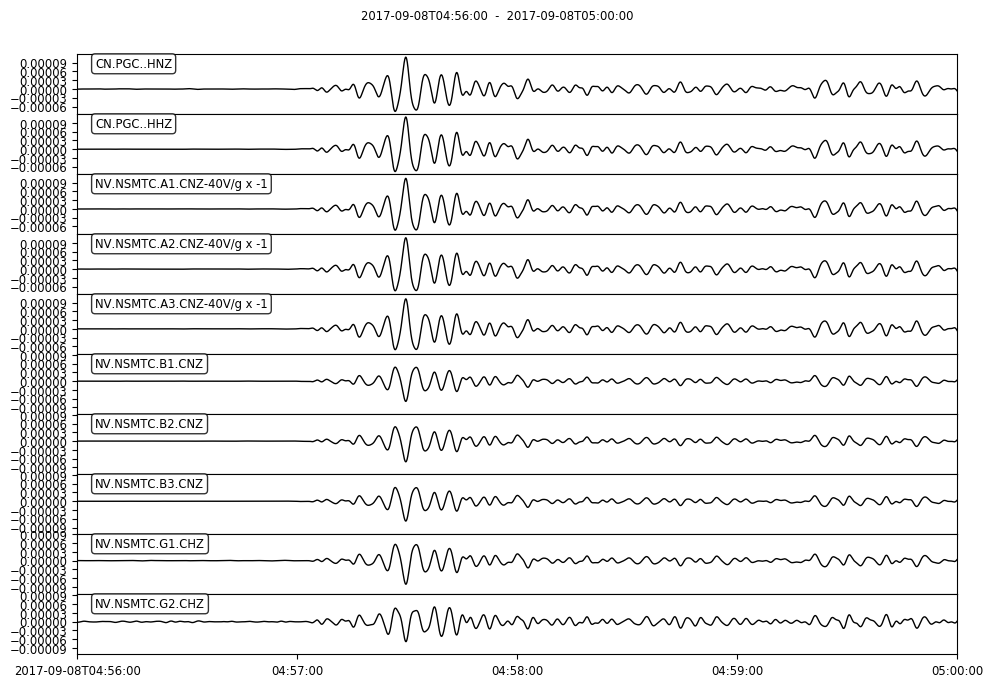

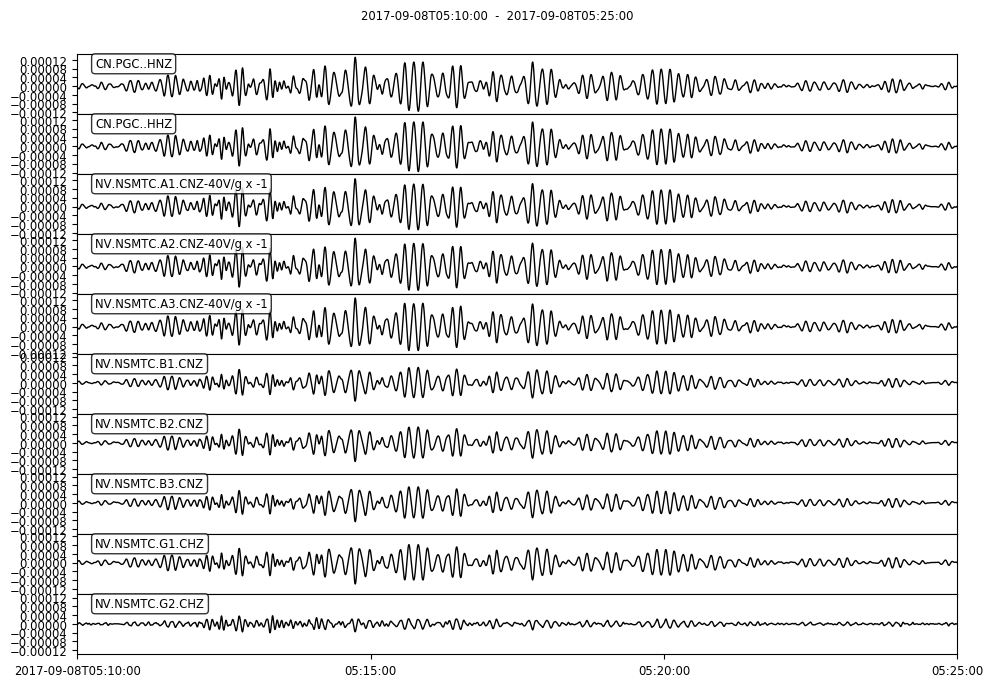

In [14]:
st_all = st2.copy() + st_mod.copy() + st.copy()

st_all.detrend() # remove liner trend
st_all.detrend("demean") # demean
st_all.taper(0.05) # cosin tape

fl = 0.05 # in Hz 
fh = 0.10 # in Hz

fl = 0.10 # in Hz 
fh = 0.50 # in Hz


st_all.filter(type='bandpass', freqmin=fl, freqmax=fh, corners=6, zerophase=True)


### plotting the first arrival part ###
t1 = UTCDateTime("2017-09-08T04:56:00.00")
t2 = UTCDateTime("2017-09-08T05:00:00.00")
#_plot = st_all.plot(size=(800, 800))
_plot = st_all.plot(size=(1000, 700), starttime=t1, endtime=t2)
### plotting the first arrival part ###

### plotting surace wave(?)  part ###
t1 = UTCDateTime("2017-09-08T05:10:00.00")
t2 = UTCDateTime("2017-09-08T05:25:00.00")
#_plot = st_all.plot(size=(800, 800))
_plot = st_all.plot(size=(1000, 700), starttime=t1, endtime=t2)
### plotting surace wave(?) part ###
